In [11]:
import argparse
import torch
import time
import numpy as np
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from torch.nn import MSELoss
from bondnet.data.dataset import ReactionNetworkDataset
from bondnet.data.dataloader import DataLoaderReactionNetwork
from bondnet.data.featurizer import (
    AtomFeaturizerMinimum,
    AtomFeaturizerFull,
    BondAsNodeFeaturizerMinimum,
    GlobalFeaturizer,
    BondAsNodeFeaturizerFull,
)
from bondnet.data.grapher import HeteroMoleculeGraph
from bondnet.data.dataset import train_validation_test_split
from bondnet.model.gated_reaction_network import GatedGCNReactionNetwork
from bondnet.scripts.create_label_file import read_input_files
from bondnet.model.metric import WeightedL1Loss
from bondnet.prediction.load_model import load_dataset, load_model
from bondnet.utils import seed_torch
from torchsummary import summary


def train(optimizer, model, nodes, data_loader, loss_fn, metric_fn):
    model.train()

    epoch_loss = 0.0
    accuracy = 0.0
    count = 0.0

    for it, (batched_graph, label) in enumerate(data_loader):
        feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
        target = label["value"]
        stdev = label["scaler_stdev"]

        pred = model(batched_graph, feats, label["reaction"])
        pred = pred.view(-1)

        loss = loss_fn(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # here is the actual optimizer step

        epoch_loss += loss.detach().item()
        accuracy += metric_fn(pred, target, stdev).detach().item()
        count += len(target)

    epoch_loss /= it + 1
    accuracy /= count

    return epoch_loss, accuracy


def evaluate(model, nodes, data_loader, metric_fn):
    model.eval()

    with torch.no_grad():
        accuracy = 0.0
        count = 0.0

        for batched_graph, label in data_loader:
            feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
            target = label["value"]
            stdev = label["scaler_stdev"]

            pred = model(batched_graph, feats, label["reaction"])
            pred = pred.view(-1)

            accuracy += metric_fn(pred, target, stdev).detach().item()
            count += len(target)

    return accuracy / count


def get_grapher():
    atom_featurizer = AtomFeaturizerMinimum()
    bond_featurizer = BondAsNodeFeaturizerMinimum()
    # bond_featurizer = BondAsNodeFeaturizerFull()
    # our example dataset contains molecules of charges -1, 0, and 1
    global_featurizer = GlobalFeaturizer(allowed_charges=[-2, -1, 0, 1, 2])

    grapher = HeteroMoleculeGraph(atom_featurizer, bond_featurizer, global_featurizer)

    return grapher


def parse_settings(file="./input_files/input_1.txt"):
    # some default values that get written over if in the file
    test = True
    epochs = 10
    embedding_size = 24

    fc_hidden_size = [128, 64]
    fc_layers = -1
    fc_activation = "ReLU"
    fc_batch_norm = 0
    fc_dropout = 0.0

    gated_hidden_size = [64, 64, 64]
    gated_layers = -1
    gated_batch_norm = 0
    gated_graph_norm = 0
    gated_dropout = 0.0
    gated_activation = "ReLU"

    num_lstm_layers = 3
    num_lstm_iters = 5

    with open(file) as f:
        lines = f.readlines()

        for i in lines:
            if len(i.split()) > 1:
                if i.split()[0] == "test":
                    test = bool(i.split()[1])
                if i.split()[0] == "epochs":
                    epochs = int(i.split()[1])
                if i.split()[0] == "embedding_size":
                    embedding_size = int(i.split()[1])

                if i.split()[0] == "gated_hidden_size":
                    gated_hidden_size = [int(j) for j in i.split()[1:]]
                if i.split()[0] == "gated_layers":
                    gated_layers = int(i.split()[1])
                if i.split()[0] == "gated_dropout":
                    gated_dropout = float(i.split()[1])
                if i.split()[0] == "gated_graph_norm":
                    gated_graph_norm = int(i.split()[1])
                if i.split()[0] == "gated_batch_norm":
                    gated_batch_norm = int(i.split()[1])
                if i.split()[0] == "gated_activation":
                    gated_activation = str(i.split()[1])

                if i.split()[0] == "fc_hidden_size":
                    fc_hidden_size = [int(j) for j in i.split()[1:]]
                if i.split()[0] == "fc_layers":
                    fc_layers = int(i.split()[1])
                if i.split()[0] == "fc_activation":
                    fc_activation = str(i.split()[1])
                if i.split()[0] == "fc_batch_norm":
                    fc_batch_norm = int(i.split()[1])
                if i.split()[0] == "fc_dropout":
                    fc_dropout = float(i.split()[1])

                if i.split()[0] == "num_lstm_iters":
                    num_lstm_iters = int(i.split()[1])
                if i.split()[0] == "num_lstm_layers":
                    num_lstm_layers = int(i.split()[1])

        if gated_layers == -1:
            gated_layers = len(gated_hidden_size)
        if fc_layers == -1:
            fc_layers = len(fc_hidden_size)

        print("using the following settings:")
        print("--" * 20)

        print("epochs: {:1d}".format(epochs))
        print("Small Dataset?: " + str(test))
        print("embedding size: {:1d}".format(embedding_size))

        print("fc layers: {:1d}".format(fc_layers))
        print("fc hidden layer: " + str(fc_hidden_size))
        print("fc activation: " + str(fc_activation))
        print("fc batch norm: " + str(fc_batch_norm))
        print("fc dropout: {:.2f}".format(fc_dropout))

        print("gated layers: {:1d}".format(gated_layers))
        print("gated hidden layers: " + str(gated_hidden_size))
        print("gated activation: " + str(gated_activation))
        print("gated dropout: {:.2f}".format(gated_dropout))
        print("gated batch norm: " + str(gated_batch_norm))
        print("gated graph norm: " + str(gated_graph_norm))

        print("num lstm iters: " + str(num_lstm_iters))
        print("num lstm layer: " + str(num_lstm_layers))
        print("--" * 20)

        dict_ret = {}
        dict_ret["test"] = test
        dict_ret["epochs"] = epochs
        dict_ret["embedding_size"] = embedding_size

        dict_ret["fc_hidden_size"] = fc_hidden_size
        dict_ret["fc_layers"] = fc_layers
        dict_ret["fc_dropout"] = fc_dropout
        dict_ret["fc_batch_norm"] = fc_batch_norm
        dict_ret["fc_activation"] = fc_activation

        dict_ret["gated_hidden_size"] = gated_hidden_size
        dict_ret["gated_layers"] = gated_layers
        dict_ret["gated_activation"] = gated_activation
        dict_ret["gated_graph_norm"] = gated_graph_norm
        dict_ret["gated_batch_norm"] = gated_batch_norm
        dict_ret["gated_dropout"] = gated_dropout

        dict_ret["num_lstm_iters"] = num_lstm_iters
        dict_ret["num_lstm_layers"] = num_lstm_layers

        return dict_ret

In [13]:
from bondnet.utils import parse_settings

dict_ret = parse_settings(file="./input_files/input_2.txt")
model = load_model(dict_ret["model_path"])
model.gated_layers

using the following settings:
----------------------------------------
restore: True
distributed: False
batch size: 100
on gpu: False
epochs: 1000
embedding size: 24
fc layers: 2
fc hidden layer: [384, 192]
gated layers: 4
gated hidden layers: [192, 192, 192, 192]
gated fc layers: 2
num lstm iters: 6
num lstm layer: 3
num gpu: 1
hyperparam save file: ./hyper.pkl
dataset state dict: home/santiagovargas/Documents/Dataset/mg/dataset_state_dict.pkl
model dir/home/santiagovargas/Documents/Dataset/mg/
Small Dataset?: False
lr: 0.001000
weight decay: 0.000
fc activation: ReLU
fc batch norm: 0
fc dropout: 0.00
gated activation: ReLU
gated dropout: 0.10
gated batch norm: True
gated graph norm: 0
gated resid: True
----------------------------------------


ModuleList(
  (0): GatedGCNConv(
    (activation): ReLU()
    (A): LinearN(
      (fc_layers): ModuleList(
        (0): Linear(in_features=24, out_features=192, bias=True)
        (1): ReLU()
        (2): Linear(in_features=192, out_features=192, bias=True)
        (3): Identity()
      )
    )
    (B): LinearN(
      (fc_layers): ModuleList(
        (0): Linear(in_features=24, out_features=192, bias=True)
        (1): ReLU()
        (2): Linear(in_features=192, out_features=192, bias=True)
        (3): Identity()
      )
    )
    (C): LinearN(
      (fc_layers): ModuleList(
        (0): Linear(in_features=24, out_features=192, bias=True)
        (1): ReLU()
        (2): Linear(in_features=192, out_features=192, bias=True)
        (3): Identity()
      )
    )
    (D): LinearN(
      (fc_layers): ModuleList(
        (0): Linear(in_features=24, out_features=192, bias=True)
        (1): ReLU()
        (2): Linear(in_features=192, out_features=192, bias=True)
        (3): Identity()
    

In [9]:
if bool(dict_ret["test"]):
    mols, attrs, labels = read_input_files(
        "examples/train/molecules.sdf",
        "examples/train/molecule_attributes.yaml",
        "examples/train/reactions.yaml",
    )
else:
    # todo
    # mols, attrs, labels = read_input_files(
    #    'examples/train/molecules_libe.sdf',
    #    'examples/train/molecule_attributes_libe.yaml',
    #    'examples/train/reactions_libe.yaml',
    # )

    # todo
    # mols_mg, attrs_mg, labels_mg = read_input_files(
    #    '../train/molecules_libe.sdf',
    #    '../train/train/molecule_attributes_libe.yaml',
    #    '../train/train/reactions_libe.yaml',
    # )

    mols, attrs, labels = read_input_files(
        "examples/train/molecules.sdf",
        "examples/train/molecule_attributes.yaml",
        "examples/train/reactions.yaml",
    )

    print("sheesh")
    # mols, attrs , labels = read_input_files()


# dataset = ReactionNetworkDataset(
#    grapher=get_grapher(),
#    molecules=mols,
#    labels=labels,
#    extra_features=attrs
# )
# def load_dataset(model_path, molecules, labels, extra_features):
model = load_model(dict_ret["model_path"])
dataset = load_dataset(
    dict_ret["model_path"], molecules=mols, labels=labels, extra_features=attrs
)


trainset, valset, testset = train_validation_test_split(
    dataset, validation=0.1, test=0.1
)

# we train with a batch size of 100
train_loader = DataLoaderReactionNetwork(trainset, batch_size=100, shuffle=True)
val_loader = DataLoaderReactionNetwork(valset, batch_size=len(valset), shuffle=False)
test_loader = DataLoaderReactionNetwork(testset, batch_size=len(testset), shuffle=False)

sheesh


ValueError: Model trained with a dataset having species: C,F,H,Mg,N,O,S; Cannot make predictions for molecule containing species: Li. Note that two models trained on different datasets are provided: the `pubchem` supports C, H, O, N and the `bdncm` supports C, H, O, F, Li. You may want to switch the model if you see this message.

In [ ]:
print("required_features: 15, 7, 9")
print(dataset.feature_size)

required_features: 15, 7, 9
{'atom': 13, 'bond': 7, 'global': 8}


In [16]:
model = GatedGCNReactionNetwork(
    in_feats=dataset.feature_size,
    embedding_size=dict_ret["embedding_size"],
    gated_num_layers=dict_ret["gated_num_layers"],
    gated_hidden_size=dict_ret["gated_hidden_size"],
    gated_activation=dict_ret["gated_activation"],
    gated_dropout=float(dict_ret["gated_dropout"]),
    gated_graph_norm=int(dict_ret["gated_graph_norm"]),
    gated_batch_norm=int(dict_ret["gated_batch_norm"]),
    fc_num_layers=dict_ret["fc_layers"],
    fc_hidden_size=dict_ret["fc_hidden_size"],
    fc_activation=dict_ret["fc_activation"],
    fc_dropout=float(dict_ret["fc_dropout"]),
    fc_batch_norm=int(dict_ret["fc_batch_norm"]),
    num_lstm_iters=dict_ret["num_lstm_iters"],
    num_lstm_layers=dict_ret["num_lstm_layers"],
    conv="GatedGCNConv",
)

# optimizer, loss function and metric function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = MSELoss(reduction="mean")
metric = WeightedL1Loss(reduction="sum")
feature_names = ["atom", "bond", "global"]
best = 1e10

# main training loop
print("# Epoch     Loss         TrainAcc        ValAcc")
t1 = time.time()

for epoch in range(dict_ret["epochs"]):
    if epoch % 5 == 0:
        # train on training set
        loss, train_acc = train(
            optimizer, model, feature_names, train_loader, loss_func, metric
        )

        # evaluate on validation set
        val_acc = evaluate(model, feature_names, val_loader, metric)

        # save checkpoint for best performing model
        if val_acc < best:
            best = val_acc
            torch.save(model.state_dict(), "checkpoint.pkl")

        print(
            "{:5d}   {:12.6e}   {:12.6e}   {:12.6e}".format(
                epoch, loss, train_acc, val_acc
            )
        )
t2 = time.time()


# load best performing model and test it's performance on the test set
checkpoint = torch.load("checkpoint.pkl")
model.load_state_dict(checkpoint)
test_acc = evaluate(model, feature_names, test_loader, metric)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("TestAcc: {:12.6e}".format(test_acc))
print("Time to Train: {:5.1f} seconds".format(float(t2 - t1)))
print("Number of Trainable Model Params: {}".format(params))


model = GatedGCNReactionNetwork(
    in_feats=dataset.feature_size,
    embedding_size=dict_ret["embedding_size"],
    gated_num_layers=dict_ret["gated_num_layers"],
    gated_hidden_size=dict_ret["gated_hidden_size"],
    gated_activation=dict_ret["gated_activation"],
    gated_dropout=float(dict_ret["gated_dropout"]),
    gated_graph_norm=int(dict_ret["gated_graph_norm"]),
    gated_batch_norm=int(dict_ret["gated_batch_norm"]),
    gated_residual=dict_ret["gated_residual"],
    gated_num_fc_layers=dict_ret["gated_num_fc_layers"],
    fc_num_layers=dict_ret["fc_layers"],
    fc_hidden_size=dict_ret["fc_hidden_size"],
    fc_activation=dict_ret["fc_activation"],
    fc_dropout=float(dict_ret["fc_dropout"]),
    fc_batch_norm=int(dict_ret["fc_batch_norm"]),
    num_lstm_iters=dict_ret["num_lstm_iters"],
    num_lstm_layers=dict_ret["num_lstm_layers"],
    conv="GatedGCNConv",
)

print("-" * 20 + "now disabling gradients" + "-" * 20)
model.gated_layers.requires_grad_(False)

# model.fc_layers.requires_grad_(False)
# model.readout_layer.requires_grad_(False)


best = 1e10

# main training loop
print("# Epoch     Loss         TrainAcc        ValAcc")
t1 = time.time()

for epoch in range(dict_ret["epochs"]):
    if epoch % 5 == 0:
        # train on training set
        loss, train_acc = train(
            optimizer, model, feature_names, train_loader, loss_func, metric
        )

        # evaluate on validation set
        val_acc = evaluate(model, feature_names, val_loader, metric)

        # save checkpoint for best performing model

        if val_acc < best:
            best = val_acc
            torch.save(model.state_dict(), "checkpoint.pkl")

        print(
            "{:5d}   {:12.6e}   {:12.6e}   {:12.6e}".format(
                epoch, loss, train_acc, val_acc
            )
        )

t2 = time.time()


feature_names = ["atom", "bond", "global"]

# load best performing model and test it's performance on the test set
from os.path import expanduser

# home = expanduser("~")
# model_directory = home+"/Documents/Dataset/mg/checkpoint.pkl"

# checkpoint = torch.load(model_directory)
# model.load_state_dict(checkpoint['model'])
# test_acc = evaluate(model, feature_names, test_loader, metric)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("TestAcc: {:12.6e}".format(test_acc))
print("Time to Train: {:5.1f} seconds".format(float(t2 - t1)))
print("Number of Trainable Model Params: {}".format(params))

# Epoch     Loss         TrainAcc        ValAcc
    0   8.354622e-01   2.457747e+00   2.090321e+00
    5   5.997426e-01   2.131326e+00   1.854207e+00
   10   3.939752e-01   1.736316e+00   1.741784e+00
   15   4.004955e-01   1.777406e+00   1.947630e+00
   20   3.577470e-01   1.632960e+00   1.456190e+00
   25   2.316015e-01   1.361877e+00   1.209444e+00
   30   2.086340e-01   1.235057e+00   1.274223e+00
   35   2.070761e-01   1.257603e+00   1.237815e+00
   40   1.872679e-01   1.174746e+00   1.171825e+00
   45   1.694346e-01   1.121845e+00   1.209740e+00
   50   1.505942e-01   1.087599e+00   1.227573e+00
   55   1.248520e-01   1.002119e+00   1.212870e+00
   60   1.600399e-01   1.060676e+00   1.172067e+00
   65   1.364062e-01   1.022181e+00   1.232711e+00
   70   1.377577e-01   1.037374e+00   1.191099e+00
   75   1.240184e-01   9.555707e-01   1.293485e+00
   80   1.012025e-01   8.473748e-01   1.273484e+00
   85   9.228709e-02   8.663695e-01   1.098703e+00
   90   7.441843e-02   7.834238e-0

KeyboardInterrupt: 

In [16]:
from os.path import expanduser

model = GatedGCNReactionNetwork(
    in_feats=dataset.feature_size,
    embedding_size=dict_ret["embedding_size"],
    gated_num_layers=dict_ret["gated_num_layers"],
    gated_hidden_size=dict_ret["gated_hidden_size"],
    gated_activation=dict_ret["gated_activation"],
    gated_dropout=float(dict_ret["gated_dropout"]),
    gated_graph_norm=int(dict_ret["gated_graph_norm"]),
    gated_batch_norm=int(dict_ret["gated_batch_norm"]),
    gated_residual=dict_ret["gated_residual"],
    gated_num_fc_layers=dict_ret["gated_num_fc_layers"],
    fc_num_layers=dict_ret["fc_layers"],
    fc_hidden_size=dict_ret["fc_hidden_size"],
    fc_activation=dict_ret["fc_activation"],
    fc_dropout=float(dict_ret["fc_dropout"]),
    fc_batch_norm=int(dict_ret["fc_batch_norm"]),
    num_lstm_iters=dict_ret["num_lstm_iters"],
    num_lstm_layers=dict_ret["num_lstm_layers"],
    conv="GatedGCNConv",
)

print("-" * 20 + "now disabling gradients" + "-" * 20)
model.gated_layers.requires_grad_(False)


checkpoint = torch.load("checkpoint.pkl")
model.load_state_dict(checkpoint)

--------------------now disabling gradients--------------------


RuntimeError: Error(s) in loading state_dict for GatedGCNReactionNetwork:
	Missing key(s) in state_dict: "gated_layers.3.A.fc_layers.0.weight", "gated_layers.3.A.fc_layers.0.bias", "gated_layers.3.A.fc_layers.2.weight", "gated_layers.3.A.fc_layers.2.bias", "gated_layers.3.B.fc_layers.0.weight", "gated_layers.3.B.fc_layers.0.bias", "gated_layers.3.B.fc_layers.2.weight", "gated_layers.3.B.fc_layers.2.bias", "gated_layers.3.C.fc_layers.0.weight", "gated_layers.3.C.fc_layers.0.bias", "gated_layers.3.C.fc_layers.2.weight", "gated_layers.3.C.fc_layers.2.bias", "gated_layers.3.D.fc_layers.0.weight", "gated_layers.3.D.fc_layers.0.bias", "gated_layers.3.D.fc_layers.2.weight", "gated_layers.3.D.fc_layers.2.bias", "gated_layers.3.E.fc_layers.0.weight", "gated_layers.3.E.fc_layers.0.bias", "gated_layers.3.E.fc_layers.2.weight", "gated_layers.3.E.fc_layers.2.bias", "gated_layers.3.F.fc_layers.0.weight", "gated_layers.3.F.fc_layers.0.bias", "gated_layers.3.F.fc_layers.2.weight", "gated_layers.3.F.fc_layers.2.bias", "gated_layers.3.G.fc_layers.0.weight", "gated_layers.3.G.fc_layers.0.bias", "gated_layers.3.G.fc_layers.2.weight", "gated_layers.3.G.fc_layers.2.bias", "gated_layers.3.H.fc_layers.0.weight", "gated_layers.3.H.fc_layers.0.bias", "gated_layers.3.H.fc_layers.2.weight", "gated_layers.3.H.fc_layers.2.bias", "gated_layers.3.I.fc_layers.0.weight", "gated_layers.3.I.fc_layers.0.bias", "gated_layers.3.I.fc_layers.2.weight", "gated_layers.3.I.fc_layers.2.bias", "gated_layers.3.bn_node_h.weight", "gated_layers.3.bn_node_h.bias", "gated_layers.3.bn_node_h.running_mean", "gated_layers.3.bn_node_h.running_var", "gated_layers.3.bn_node_e.weight", "gated_layers.3.bn_node_e.bias", "gated_layers.3.bn_node_e.running_mean", "gated_layers.3.bn_node_e.running_var", "gated_layers.3.bn_node_u.weight", "gated_layers.3.bn_node_u.bias", "gated_layers.3.bn_node_u.running_mean", "gated_layers.3.bn_node_u.running_var", "fc_layers.2.weight", "fc_layers.2.bias". 
	Unexpected key(s) in state_dict: "readout_layer.layers.atom.lstm.weight_ih_l3", "readout_layer.layers.atom.lstm.weight_hh_l3", "readout_layer.layers.atom.lstm.bias_ih_l3", "readout_layer.layers.atom.lstm.bias_hh_l3", "readout_layer.layers.atom.lstm.weight_ih_l4", "readout_layer.layers.atom.lstm.weight_hh_l4", "readout_layer.layers.atom.lstm.bias_ih_l4", "readout_layer.layers.atom.lstm.bias_hh_l4", "readout_layer.layers.bond.lstm.weight_ih_l3", "readout_layer.layers.bond.lstm.weight_hh_l3", "readout_layer.layers.bond.lstm.bias_ih_l3", "readout_layer.layers.bond.lstm.bias_hh_l3", "readout_layer.layers.bond.lstm.weight_ih_l4", "readout_layer.layers.bond.lstm.weight_hh_l4", "readout_layer.layers.bond.lstm.bias_ih_l4", "readout_layer.layers.bond.lstm.bias_hh_l4", "fc_layers.6.weight", "fc_layers.6.bias", "fc_layers.1.weight", "fc_layers.1.bias", "fc_layers.1.running_mean", "fc_layers.1.running_var", "fc_layers.1.num_batches_tracked", "fc_layers.3.weight", "fc_layers.3.bias", "fc_layers.4.running_mean", "fc_layers.4.running_var", "fc_layers.4.num_batches_tracked". 
	size mismatch for gated_layers.0.A.fc_layers.0.weight: copying a param with shape torch.Size([64, 24]) from checkpoint, the shape in current model is torch.Size([192, 24]).
	size mismatch for gated_layers.0.A.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.A.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.A.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.B.fc_layers.0.weight: copying a param with shape torch.Size([64, 24]) from checkpoint, the shape in current model is torch.Size([192, 24]).
	size mismatch for gated_layers.0.B.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.B.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.B.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.C.fc_layers.0.weight: copying a param with shape torch.Size([64, 24]) from checkpoint, the shape in current model is torch.Size([192, 24]).
	size mismatch for gated_layers.0.C.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.C.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.C.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.D.fc_layers.0.weight: copying a param with shape torch.Size([64, 24]) from checkpoint, the shape in current model is torch.Size([192, 24]).
	size mismatch for gated_layers.0.D.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.D.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.D.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.E.fc_layers.0.weight: copying a param with shape torch.Size([64, 24]) from checkpoint, the shape in current model is torch.Size([192, 24]).
	size mismatch for gated_layers.0.E.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.E.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.E.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.F.fc_layers.0.weight: copying a param with shape torch.Size([64, 24]) from checkpoint, the shape in current model is torch.Size([192, 24]).
	size mismatch for gated_layers.0.F.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.F.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.F.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.G.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.G.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.G.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.G.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.H.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.H.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.H.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.H.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.I.fc_layers.0.weight: copying a param with shape torch.Size([64, 24]) from checkpoint, the shape in current model is torch.Size([192, 24]).
	size mismatch for gated_layers.0.I.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.I.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.0.I.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_h.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_h.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_h.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_h.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_e.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_e.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_e.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_e.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_u.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_u.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_u.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.0.bn_node_u.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.A.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.A.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.A.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.A.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.B.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.B.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.B.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.B.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.C.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.C.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.C.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.C.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.D.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.D.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.D.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.D.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.E.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.E.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.E.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.E.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.F.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.F.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.F.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.F.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.G.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.G.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.G.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.G.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.H.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.H.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.H.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.H.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.I.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.I.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.I.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.1.I.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_h.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_h.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_h.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_h.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_e.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_e.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_e.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_e.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_u.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_u.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_u.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.1.bn_node_u.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.A.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.A.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.A.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.A.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.B.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.B.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.B.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.B.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.C.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.C.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.C.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.C.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.D.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.D.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.D.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.D.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.E.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.E.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.E.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.E.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.F.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.F.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.F.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.F.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.G.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.G.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.G.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.G.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.H.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.H.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.H.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.H.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.I.fc_layers.0.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.I.fc_layers.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.I.fc_layers.2.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([192, 192]).
	size mismatch for gated_layers.2.I.fc_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_h.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_h.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_h.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_h.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_e.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_e.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_e.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_e.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_u.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_u.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_u.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for gated_layers.2.bn_node_u.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for readout_layer.layers.atom.lstm.weight_ih_l0: copying a param with shape torch.Size([256, 128]) from checkpoint, the shape in current model is torch.Size([768, 384]).
	size mismatch for readout_layer.layers.atom.lstm.weight_hh_l0: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.atom.lstm.bias_ih_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.atom.lstm.bias_hh_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.atom.lstm.weight_ih_l1: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.atom.lstm.weight_hh_l1: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.atom.lstm.bias_ih_l1: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.atom.lstm.bias_hh_l1: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.atom.lstm.weight_ih_l2: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.atom.lstm.weight_hh_l2: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.atom.lstm.bias_ih_l2: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.atom.lstm.bias_hh_l2: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.bond.lstm.weight_ih_l0: copying a param with shape torch.Size([256, 128]) from checkpoint, the shape in current model is torch.Size([768, 384]).
	size mismatch for readout_layer.layers.bond.lstm.weight_hh_l0: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.bond.lstm.bias_ih_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.bond.lstm.bias_hh_l0: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.bond.lstm.weight_ih_l1: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.bond.lstm.weight_hh_l1: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.bond.lstm.bias_ih_l1: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.bond.lstm.bias_hh_l1: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.bond.lstm.weight_ih_l2: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.bond.lstm.weight_hh_l2: copying a param with shape torch.Size([256, 64]) from checkpoint, the shape in current model is torch.Size([768, 192]).
	size mismatch for readout_layer.layers.bond.lstm.bias_ih_l2: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for readout_layer.layers.bond.lstm.bias_hh_l2: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for fc_layers.0.weight: copying a param with shape torch.Size([32, 320]) from checkpoint, the shape in current model is torch.Size([384, 960]).
	size mismatch for fc_layers.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for fc_layers.4.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([1, 192]).
	size mismatch for fc_layers.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([1]).

In [18]:
model = GatedGCNReactionNetwork(
    in_feats=dataset.feature_size,
    embedding_size=dict_ret["embedding_size"],
    gated_num_layers=dict_ret["gated_num_layers"],
    gated_hidden_size=dict_ret["gated_hidden_size"],
    gated_activation=dict_ret["gated_activation"],
    gated_dropout=float(dict_ret["gated_dropout"]),
    gated_graph_norm=int(dict_ret["gated_graph_norm"]),
    gated_batch_norm=int(dict_ret["gated_batch_norm"]),
    gated_residual=dict_ret["gated_residual"],
    gated_num_fc_layers=dict_ret["gated_num_fc_layers"],
    fc_num_layers=dict_ret["fc_layers"],
    fc_hidden_size=dict_ret["fc_hidden_size"],
    fc_activation=dict_ret["fc_activation"],
    fc_dropout=float(dict_ret["fc_dropout"]),
    fc_batch_norm=int(dict_ret["fc_batch_norm"]),
    num_lstm_iters=dict_ret["num_lstm_iters"],
    num_lstm_layers=dict_ret["num_lstm_layers"],
    conv="GatedGCNConv",
)

from os.path import expanduser

home = expanduser("~")
model_ref = home + "/Documents/Dataset/mg/"

# checkpoint = torch.load(model_ref + "checkpoint.pkl")
# model.load_state_dict(checkpoint["model"])

TypeError: 'method' object is not iterable

In [42]:
import pandas as pd
import networkx as nx

path_mg_data = "/home/santiagovargas/Documents/Dataset/mg_dataset/"
path_json = path_mg_data + "20220613_reaction_data.json"
mg_df = pd.read_json(path_json)

In [104]:
from bondnet.core.molwrapper import create_wrapper_mol_from_atoms_and_bonds
from bondnet.core.reaction import Reaction

error = 0
two_product_count = 0
three_prouct_count = 0

for index, row in mg_df.iterrows():
    # handle reactant
    species = [i["name"] for i in row["reactant_molecule_graph"]["molecule"]["sites"]]
    coords = [i["xyz"] for i in row["reactant_molecule_graph"]["molecule"]["sites"]]
    bonds = row["reactant_bonds"]
    charge = row["charge"]

    reactant = create_wrapper_mol_from_atoms_and_bonds(
        species, coords, bonds, charge=charge
    )
    reactant_list = [reactant]

    # handle products
    # check subgraphs first
    product_list = []
    num_nodes = 0
    for i in row["composition"].items():
        num_nodes += int(i[-1])
    G = nx.Graph()
    G.add_nodes_from([int(i) for i in range(num_nodes)])
    for i in row["product_bonds"]:
        G.add_edge(i[0], i[1])
    sub_graphs = [G.subgraph(c) for c in nx.connected_components(G)]

    # still no handling for rxns A --> B + C +....
    if len(sub_graphs) > 2:
        three_prouct_count += 1
    # handle A --> B + C
    elif len(sub_graphs) == 2:
        product_list = []
        for sg in sub_graphs:
            two_product_count += 1
            nodes = list(sg.nodes())
            bonds = list(sg.edges())
            bond_reindex_list = []
            species = [
                row["product_molecule_graph"]["molecule"]["sites"][sub_ind]["name"]
                for sub_ind in list(sg.nodes())
            ]
            coords = [
                row["product_molecule_graph"]["molecule"]["sites"][sub_ind]["xyz"]
                for sub_ind in list(sg.nodes())
            ]
            charge = row["charge"]
            for origin_bond_ind in row["product_bonds"]:
                check = any(item in origin_bond_ind for item in nodes)
                if check:
                    bond_orig = nodes.index(origin_bond_ind[0])
                    bond_targ = nodes.index(origin_bond_ind[1])
                    bond_reindex_list.append([bond_orig, bond_targ])

                product = create_wrapper_mol_from_atoms_and_bonds(
                    species, coords, bond_reindex_list, charge=charge
                )
            product_list.append(product)

    # handle A --> B
    else:
        species = [
            i["name"] for i in row["product_molecule_graph"]["molecule"]["sites"]
        ]
        coords = [i["xyz"] for i in row["product_molecule_graph"]["molecule"]["sites"]]
        bonds = row["product_bonds"]
        charge = row["charge"]
        free_energy = row["product_free_energy"]
        product = create_wrapper_mol_from_atoms_and_bonds(
            species=species, coords=coords, bonds=bonds, charge=charge
        )
        product_list = [product]
    try:
        rxn = Reaction(
            reactants=reactant_list,
            products=product_list,
            broken_bond=row["bonds_broken"],
            free_energy=row["dE_barrier"],
            identifier=row["reaction_id"],
        )
    except:
        print(product_list)
        error += 1
print("number of rxn failed: " + str(error))
print("number of reactions with two products: " + str(two_product_count))
print("number of reactions with three products: " + str(three_prouct_count))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
number of rxn failed: 141
number of reactions with two products: 1326
number of reactions with three products: 141


In [83]:
# for i, sg in enumerate(sub_graphs):pass
# print(list(sg.nodes()))
# mg_df.iloc[1]['product_molecule_graph']["molecule"]["sites"][18]
# mg_df.iloc[1]['product_molecule_graph']["molecule"]["sites"][2]['name']

0


In [2]:
import torch

yhat = torch.Tensor([[0.5, 1.5, 0.1], [2.2, 1.3, 1.7]])
print(yhat)
print(yhat.shape)
# tensor([[0.5000, 1.5000, 0.1000],
#         [2.2000, 1.3000, 1.7000]])

y = torch.Tensor([1, 2]).to(torch.long)
print(y)
print(y.shape)
# tensor([1, 2])

loss = torch.nn.CrossEntropyLoss()
cel = loss(input=yhat, target=y)
print(cel)
# tensor(0.8393)

tensor([[0.5000, 1.5000, 0.1000],
        [2.2000, 1.3000, 1.7000]])
torch.Size([2, 3])
tensor([1, 2])
torch.Size([2])
tensor(0.8393)


# Aug 10


In [4]:
import torch
import time, wandb
import numpy as np
from tqdm import tqdm
from sklearn.metrics import r2_score
from torchmetrics import R2Score
from torch.optim.lr_scheduler import ReduceLROnPlateau

from bondnet.model.metric import EarlyStopping
from bondnet.data.dataset import ReactionNetworkDatasetGraphs
from bondnet.data.dataloader import DataLoaderReactionNetwork
from bondnet.data.dataset import train_validation_test_split

# from bondnet.scripts.create_label_file import read_input_files
# from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss
from bondnet.utils import seed_torch, pickle_dump, parse_settings
from bondnet.model.training_utils import (
    evaluate,
    evaluate_classifier,
    train,
    train_classifier,
    load_model,
    evaluate_r2,
    get_grapher,
)

seed_torch()

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
best = 1e10
feature_names = ["atom", "bond", "global"]
path_mg_data = "../dataset/mg_dataset/"
dict_train = parse_settings(file="settings.txt")
path_mg_data = "../../../dataset/mg_dataset/20220613_reaction_data.json"

using the following settings:
----------------------------------------
Small Dataset?: False
restore: True
distributed: False
on gpu: False
num gpu: 1
hyperparam save file: ./hyper.pkl
dataset state dict: home/santiagovargas/Documents/Dataset/mg/dataset_state_dict.pkl
model dir /home/santiagovargas/Documents/Dataset/mg/
classifier False
batch size: 256
epochs: 100
lr: 0.000100
weight decay: 0.000
early_stop: True
scheduler: True
transfer_epochs: 100
transfer: False
loss: False
categories: 3
embedding size: 24
fc layers: 2
fc hidden layer: [128, 64]
gated layers: 3
gated hidden layers: [64, 64, 64]
num lstm iters: 6
num lstm layer: 3
gated fc layers: 2
fc activation: ReLU
fc batch norm: 0
fc dropout: 0.00
gated activation: ReLU
gated dropout: 0.10
gated batch norm: True
gated graph norm: 0
gated resid: True
----------------------------------------


In [6]:
if dict_train["classifier"]:
    classif_categories = 5  # update this later
else:
    classif_categories = None

if dict_train["on_gpu"]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dict_train["gpu"] = device
else:
    device = torch.device("cpu")
    dict_train["gpu"] = "cpu"

print("train on device: {}".format(dict_train["gpu"]))

train on device: cpu


In [7]:
path_mg_data = "../dataset/mg_dataset/20220613_reaction_data.json"

dataset = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(),
    file=path_mg_data,
    out_file="./",
    target="ts",
    classifier=dict_train["classifier"],
    classif_categories=classif_categories,
    debug=dict_train["debug"],
    device=device,
)

dataset_transfer = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(),
    file=path_mg_data,
    out_file="./",
    target="diff",
    classifier=dict_train["classifier"],
    classif_categories=classif_categories,
    debug=dict_train["debug"],
    device=device,
)

reading file from: ../dataset/mg_dataset/20220613_reaction_data.json
rxn raw len: 3001
Program finished in 14.417848569999478 seconds
.............failures.............
reactions len: 550
valid ind len: 550
bond break fail count: 		0
default fail count: 		2451
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 550


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



features: 1372
labels: 550
molecules: 1372
constructing graphs & features....
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
number of graphs valid: 1372
number of graphs: 1372
reading file from: ../dataset/mg_dataset/20220613_reaction_data.json
rxn raw len: 3001
Program finished in 14.515308740999899 seconds
.............failures.............
reactions len: 550
valid ind len: 550
bond break fail count: 		0
default fail count: 		2451
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 550


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



features: 1372
labels: 550
molecules: 1372
constructing graphs & features....
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
number of graphs valid: 1372
number of graphs: 1372


In [8]:
for it, (bg, label) in enumerate(train_loader):
    print(bg.device)

cuda:0


In [6]:
import numpy as np
import torch, wandb
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchmetrics import F1Score

from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss
from bondnet.model.gated_reaction_network import GatedGCNReactionNetwork
from bondnet.model.gated_reaction_network_classifier import (
    GatedGCNReactionNetworkClassifier,
)

In [8]:
dict_train["in_feats"] = dataset.feature_size
model, optimizer, optimizer_transfer = load_model(dict_train)
model.to(device)

trainset, valset, testset = train_validation_test_split(
    dataset, validation=0.15, test=0.15
)

train_loader = DataLoaderReactionNetwork(
    trainset, batch_size=dict_train["batch_size"], shuffle=True
)
val_loader = DataLoaderReactionNetwork(valset, batch_size=len(valset), shuffle=False)
test_loader = DataLoaderReactionNetwork(testset, batch_size=len(testset), shuffle=False)

scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.4, patience=25, verbose=True
)
stopper = EarlyStopping(patience=150)
stopper_transfer = EarlyStopping(patience=150)

if True:
    trainset_transfer, valset_tranfer, _ = train_validation_test_split(
        dataset_transfer, validation=0.15, test=0.01
    )
    dataset_transfer_loader = DataLoaderReactionNetwork(
        trainset_transfer, batch_size=dict_train["batch_size"], shuffle=True
    )
    dataset_transfer_loader_val = DataLoaderReactionNetwork(
        valset_tranfer, batch_size=dict_train["batch_size"], shuffle=True
    )

    print("Initiating Training w/ transfer...")
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Number of Trainable Model Params: {}".format(params))

    for epoch in tqdm(range(dict_train["transfer_epochs"])):
        if dict_train["classifier"]:
            _, _ = train_classifier(
                model,
                feature_names,
                dataset_transfer_loader,
                optimizer,
                device=dict_train["gpu"],
                categories=classif_categories,
            )
            val_acc_transfer, f1_score = evaluate_classifier(
                model,
                feature_names,
                dataset_transfer_loader_val,
                device=dict_train["gpu"],
                categories=classif_categories,
            )
        else:
            _, _ = train(
                model,
                feature_names,
                dataset_transfer_loader,
                optimizer,
                device=dict_train["gpu"],
            )
            val_acc_transfer = evaluate(
                model,
                feature_names,
                dataset_transfer_loader_val,
                device=dict_train["gpu"],
            )

        if stopper_transfer.step(val_acc_transfer):
            break

    # freeze model layers but fc
    model.gated_layers.requires_grad_(False)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Freezing Gated Layers....")
    print("Number of Trainable Model Params: {}".format(params))

t1 = time.time()
# optimizer, loss function and metric function
# main training loop
if dict_train["classifier"]:
    print("# Epoch     Loss         TrainAcc        ValAcc        ValF1")
else:
    print("# Epoch     Loss         TrainAcc        ValAcc        ValR2")

for epoch in range(dict_train["epochs"]):
    # train on training set
    if dict_train["classifier"]:
        loss, train_acc = train_classifier(
            model,
            feature_names,
            train_loader,
            optimizer,
            device=dict_train["gpu"],
            categories=classif_categories,
        )

        # evaluate on validation set
        val_acc, f1_score = evaluate_classifier(
            model,
            feature_names,
            val_loader,
            device=dict_train["gpu"],
            categories=classif_categories,
        )

        wandb.log({"acc validation": val_acc})
        wandb.log({"f1 validation": f1_score})
        print(
            "{:5d}   {:12.6e}   {:12.2e}   {:12.6e}   {:.2f}".format(
                epoch, loss, train_acc, val_acc, f1_score
            )
        )

    else:
        loss, train_acc = train(
            model, feature_names, train_loader, optimizer, dict_train["gpu"]
        )
        # evaluate on validation set
        val_acc = evaluate(model, feature_names, val_loader, dict_train["gpu"])
        val_r2 = evaluate_r2(model, feature_names, val_loader)

        print(
            "{:5d}   {:12.6e}   {:12.2e}   {:12.6e}   {:.2f}".format(
                epoch, loss, train_acc, val_acc, val_r2
            )
        )

    # save checkpoint for best performing model
    is_best = val_acc < best
    if is_best:
        best = val_acc
        torch.save(model.state_dict(), "checkpoint.pkl")

    if dict_train["early_stop"]:
        if stopper.step(val_acc):
            pickle_dump(
                best, dict_train["save_hyper_params"]
            )  # save results for hyperparam tune
            break
    scheduler.step(val_acc)

checkpoint = torch.load("checkpoint.pkl")
model.load_state_dict(checkpoint)

if dict_train["classifier"]:
    test_acc, test_f1 = evaluate_classifier(
        model,
        feature_names,
        test_loader,
        device=dict_train["gpu"],
        categories=classif_categories,
    )
    print("Test Acc: {:12.6e}".format(test_acc))
    print("Test F1: {:12.6e}".format(test_f1))


else:
    test_acc = evaluate(model, feature_names, test_loader)
    print("TestAcc: {:12.6e}".format(test_acc))

t2 = time.time()
print("Time to Training: {:5.1f} seconds".format(float(t2 - t1)))

Initiating Training w/ transfer...
Number of Trainable Model Params: 378177


100%|██████████| 100/100 [04:59<00:00,  2.99s/it]


Freezing Gated Layers....
Number of Trainable Model Params: 282625
# Epoch     Loss         TrainAcc        ValAcc        ValR2
    0   5.838395e-01       5.86e-01   7.375593e-01   -0.05
    1   5.697868e-01       5.87e-01   7.308374e-01   -0.05
    2   5.829880e-01       5.71e-01   7.175438e-01   -0.04
    3   5.574794e-01       5.58e-01   7.077865e-01   -0.00
    4   5.375884e-01       5.28e-01   7.008233e-01   0.02
    5   5.129869e-01       5.16e-01   6.963155e-01   0.04
    6   5.009432e-01       5.09e-01   6.927217e-01   0.05
    7   5.023253e-01       5.01e-01   6.913143e-01   0.05
    8   4.861548e-01       4.94e-01   6.868426e-01   0.06
    9   4.844654e-01       4.83e-01   6.779692e-01   0.07
   10   4.862275e-01       4.80e-01   6.680047e-01   0.07
   11   4.744842e-01       4.59e-01   6.621695e-01   0.07
   12   4.487586e-01       4.59e-01   6.590375e-01   0.07
   13   4.478369e-01       4.50e-01   6.578994e-01   0.07
   14   4.340080e-01       4.44e-01   6.581209e-01   0.0

In [18]:
import numpy as np
import torch, wandb
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchmetrics import F1Score
from sklearn.metrics import f1_score

from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss
from bondnet.model.gated_reaction_network import GatedGCNReactionNetwork
from bondnet.model.gated_reaction_network_classifier import (
    GatedGCNReactionNetworkClassifier,
)

import torch
import time, wandb
import numpy as np
from tqdm import tqdm
from sklearn.metrics import r2_score
from torchmetrics import R2Score
from torch.optim.lr_scheduler import ReduceLROnPlateau

from bondnet.model.metric import EarlyStopping
from bondnet.data.dataset import ReactionNetworkDatasetGraphs
from bondnet.data.dataloader import DataLoaderReactionNetwork
from bondnet.data.featurizer import (
    AtomFeaturizerGraph,
    BondAsNodeGraphFeaturizer,
    GlobalFeaturizerGraph,
)
from bondnet.data.grapher import (
    HeteroCompleteGraphFromDGLAndPandas,
)
from bondnet.data.dataset import train_validation_test_split

# from bondnet.scripts.create_label_file import read_input_files
# from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss
from bondnet.utils import seed_torch, pickle_dump, parse_settings
from bondnet.model.training_utils import (
    evaluate,
    evaluate_classifier,
    train,
    train_classifier,
    load_model,
)

seed_torch()

In [22]:
path_mg_data = "../dataset/mg_dataset/20220613_reaction_data.json"
settings_file = "./training_reg/2/settings.txt"
classif_categories = 5
device = None

dict_train = parse_settings(settings_file)

if device == None:
    if dict_train["on_gpu"]:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dict_train["gpu"] = device
    else:
        device = torch.device("cpu")
        dict_train["gpu"] = "cpu"
else:
    dict_train["gpu"] = device

dataset_transfer = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(),
    file=path_mg_data,
    out_file="./",
    target="diff",
    classifier=dict_train["classifier"],
    classif_categories=classif_categories,
    debug=dict_train["debug"],
    device=dict_train["gpu"],
)

dataset = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(),
    file=path_mg_data,
    out_file="./",
    target="ts",
    classifier=dict_train["classifier"],
    classif_categories=classif_categories,
    debug=dict_train["debug"],
    device=device,
)

using the following settings:
----------------------------------------
Small Dataset?: False
restore: True
distributed: False
on gpu: False
num gpu: 1
hyperparam save file: ./hyper.pkl
dataset state dict: home/santiagovargas/Documents/Dataset/mg/dataset_state_dict.pkl
model dir /home/santiagovargas/Documents/Dataset/mg/
classifier False
batch size: 256
epochs: 500
lr: 0.000100
weight decay: 0.000
early_stop: True
scheduler: True
transfer_epochs: 500
transfer: True
loss: False
categories: 5
embedding size: 24
fc layers: 2
fc hidden layer: [394, 128]
gated layers: 3
gated hidden layers: [64, 64, 64]
num lstm iters: 6
num lstm layer: 3
gated fc layers: 2
fc activation: ReLU
fc batch norm: 0
fc dropout: 0.00
gated activation: ReLU
gated dropout: 0.10
gated batch norm: True
gated graph norm: 0
gated resid: True
----------------------------------------
reading file from: ../dataset/mg_dataset/20220613_reaction_data.json
rxn raw len: 3001
Program finished in 12.270933712000442 seconds
.......

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



features: 1372
labels: 550
molecules: 1372
constructing graphs & features....
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
number of graphs valid: 1372
number of graphs: 1372
reading file from: ../dataset/mg_dataset/20220613_reaction_data.json
rxn raw len: 3001
Program finished in 14.333720992999588 seconds
.............failures.............
reactions len: 550
valid ind len: 550
bond break fail count: 		0
default fail count: 		2451
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 550


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



features: 1372
labels: 550
molecules: 1372
constructing graphs & features....
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
number of graphs valid: 1372
number of graphs: 1372


In [97]:
best = 1e10
feature_names = ["atom", "bond", "global"]
# path_mg_data = "../dataset/mg_dataset/"
dict_train = parse_settings(settings_file)
path_mg_data = "../../../dataset/mg_dataset/20220613_reaction_data.json"

if dict_train["classifier"]:
    classif_categories = 5  # update this later
    # wandb.init(project="project_classification_test")
else:
    classif_categories = None
    # wandb.init(project="project_regression_test")

if device == None:
    if dict_train["on_gpu"]:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dict_train["gpu"] = device
    else:
        device = torch.device("cpu")
        dict_train["gpu"] = "cpu"
else:
    dict_train["gpu"] = device
# wandb.config.update(dict_train)
dict_train["transfer"] = False

print("train on device: {}".format(dict_train["gpu"]))
if dataset == None:
    pass

dict_train["in_feats"] = dataset.feature_size
model, optimizer, optimizer_transfer = load_model(dict_train)
model.to(device)

trainset, valset, testset = train_validation_test_split(
    dataset, validation=0.15, test=0.15
)

train_loader = DataLoaderReactionNetwork(
    trainset, batch_size=dict_train["batch_size"], shuffle=True
)
val_loader = DataLoaderReactionNetwork(valset, batch_size=len(valset), shuffle=False)
test_loader = DataLoaderReactionNetwork(testset, batch_size=len(testset), shuffle=False)

scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.4, patience=30, verbose=True
)
scheduler_transfer = ReduceLROnPlateau(
    optimizer_transfer, mode="min", factor=0.4, patience=30, verbose=True
)
stopper = EarlyStopping(patience=150)
stopper_transfer = EarlyStopping(patience=150)

if dict_train["transfer"]:
    if dataset_transfer == None:
        pass

    trainset_transfer, valset_tranfer, _ = train_validation_test_split(
        dataset_transfer, validation=0.15, test=0.01
    )
    dataset_transfer_loader = DataLoaderReactionNetwork(
        trainset_transfer, batch_size=dict_train["batch_size"], shuffle=True
    )
    dataset_transfer_loader_val = DataLoaderReactionNetwork(
        valset_tranfer, batch_size=dict_train["batch_size"], shuffle=True
    )

    print("Initiating Training w/ transfer...")
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Number of Trainable Model Params: {}".format(params))

    for epoch in tqdm(range(dict_train["transfer_epochs"])):
        if dict_train["classifier"]:
            loss_transfer, train_acc_transfer = train_classifier(
                model,
                feature_names,
                dataset_transfer_loader,
                optimizer_transfer,
                device=dict_train["gpu"],
                categories=classif_categories,
            )
            val_acc_transfer, f1_score = evaluate_classifier(
                model,
                feature_names,
                dataset_transfer_loader_val,
                device=dict_train["gpu"],
                categories=classif_categories,
            )
            # wandb.log({"transfer_val_acc": val_acc_transfer})
            # wandb.log({"transfer_val_f1": f1_score})
            # wandb.log({"loss_transfer": loss_transfer})
            # wandb.log({"train_acc_transfer": train_acc_transfer})

        else:
            loss_transfer, train_acc_transfer = train(
                model,
                feature_names,
                dataset_transfer_loader,
                optimizer_transfer,
                device=dict_train["gpu"],
            )
            val_acc_transfer = evaluate(
                model,
                feature_names,
                dataset_transfer_loader_val,
                device=dict_train["gpu"],
            )
            # wandb.log({"loss_transfer": loss_transfer})
            # wandb.log({"train_acc_transfer": train_acc_transfer})
            # wandb.log({"val_acc_transfer": val_acc_transfer})

        scheduler_transfer.step(val_acc_transfer)
        if stopper_transfer.step(val_acc_transfer):
            break

    # freeze model layers but fc
    model.gated_layers.requires_grad_(False)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Freezing Gated Layers....")
    print("Number of Trainable Model Params: {}".format(params))

t1 = time.time()

if dict_train["classifier"]:
    print("# Epoch     Loss         TrainAcc        ValAcc        ValF1")
else:
    print("# Epoch     Loss         TrainAcc        ValAcc        ValR2")

for epoch in range(dict_train["epochs"]):
    # train on training set
    if dict_train["classifier"]:
        loss, train_acc = train_classifier(
            model,
            feature_names,
            train_loader,
            optimizer,
            device=dict_train["gpu"],
            categories=classif_categories,
        )

        # evaluate on validation set
        val_acc, f1_score = evaluate_classifier(
            model,
            feature_names,
            val_loader,
            device=dict_train["gpu"],
            categories=classif_categories,
        )

        # wandb.log({"acc validation": val_acc})
        # wandb.log({"f1 validation": f1_score})
        print(
            "{:5d}   {:12.6e}   {:12.2e}   {:12.6e}   {:.2f}".format(
                epoch, loss, train_acc, val_acc, f1_score
            )
        )

    else:
        loss, train_acc = train(
            model, feature_names, train_loader, optimizer, device=dict_train["gpu"]
        )
        # evaluate on validation set
        val_acc = evaluate(model, feature_names, val_loader, device=dict_train["gpu"])
        val_r2 = evaluate_r2(model, feature_names, val_loader, device=dict_train["gpu"])

        val_r2_test = evaluate_r2_new(
            model, feature_names, val_loader, device=dict_train["gpu"]
        )
        # wandb.log({"loss": loss})
        # wandb.log({"mae_val": val_acc})
        # wandb.log({"r2_val": val_r2})

        print(
            "{:5d}   {:12.6e}   {:12.2e}   {:12.6e}   {:.2f}   {:.2f}".format(
                epoch, loss, train_acc, val_acc, val_r2, val_r2_test
            )
        )

    # save checkpoint for best performing model
    is_best = val_acc < best
    if is_best:
        best = val_acc
        torch.save(model.state_dict(), "checkpoint.pkl")

    if dict_train["early_stop"]:
        if stopper.step(val_acc):
            pickle_dump(
                best, dict_train["save_hyper_params"]
            )  # save results for hyperparam tune
            break
    scheduler.step(val_acc)

checkpoint = torch.load("checkpoint.pkl")
model.load_state_dict(checkpoint)

if dict_train["classifier"]:
    test_acc, test_f1 = evaluate_classifier(
        model,
        feature_names,
        test_loader,
        device=dict_train["gpu"],
        categories=classif_categories,
    )

    # wandb.log({"acc validation": test_acc})
    # wandb.log({"f1 validation": test_f1})
    print("Test Acc: {:12.6e}".format(test_acc))
    print("Test F1: {:12.6e}".format(test_f1))

else:
    test_acc = evaluate(model, feature_names, test_loader, device=dict_train["gpu"])
    # wandb.log({"mae_test": test_acc})
    print("TestMAE: {:12.6e}".format(test_acc))

t2 = time.time()
print("Time to Training: {:5.1f} seconds".format(float(t2 - t1)))

using the following settings:
----------------------------------------
Small Dataset?: False
restore: True
distributed: False
on gpu: False
num gpu: 1
hyperparam save file: ./hyper.pkl
dataset state dict: home/santiagovargas/Documents/Dataset/mg/dataset_state_dict.pkl
model dir /home/santiagovargas/Documents/Dataset/mg/
classifier False
batch size: 256
epochs: 500
lr: 0.000100
weight decay: 0.000
early_stop: True
scheduler: True
transfer_epochs: 500
transfer: False
loss: False
categories: 5
embedding size: 24
fc layers: 2
fc hidden layer: [128, 64]
gated layers: 1
gated hidden layers: [128]
num lstm iters: 6
num lstm layer: 3
gated fc layers: 2
fc activation: ReLU
fc batch norm: 0
fc dropout: 0.00
gated activation: ReLU
gated dropout: 0.20
gated batch norm: True
gated graph norm: 0
gated resid: True
----------------------------------------
train on device: cpu
# Epoch     Loss         TrainAcc        ValAcc        ValR2
    0   7.077151e-01       6.97e-01   6.296959e-01   -0.02   -0.02

KeyboardInterrupt: 

In [3]:
# test_acc = evaluate(model, feature_names, test_loader, device = dict_train["gpu"])

model.eval()
with torch.no_grad():
    accuracy = 0.0
    count = 0.0
    for batched_graph, label in test_loader:
        feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in feature_names}
        target = label["value"]
        stdev = label["scaler_stdev"]
        pred = model(batched_graph, feats, label["reaction"])
        print(feats)

NameError: name 'torch' is not defined

-1.0249346


(-1.7717934846878052, 10.435993194580078)

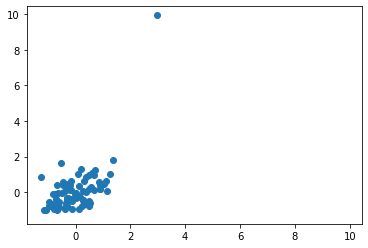

In [16]:
pred_np = pred.detach().numpy()
target_np = target.detach().numpy()

import matplotlib.pyplot as plt

plt.scatter(pred_np, target_np)
print(np.min(target_np))
min_val = np.min([np.min(pred_np), np.min(target_np)]) - 0.5
max_val = np.max([np.max(pred_np), np.max(target_np)]) + 0.5

plt.ylim(min_val, max_val)
plt.xlim(min_val, max_val)
# plt.show()

# mapping - Aug 16


In [11]:
import itertools
import numpy as np


def mapping_to_list(mappings, mode="atom"):
    """
    Given a list of mappings from products to reactants, return a representation
    (mapping expressed using a list) from reactants to products.

    Note: !!!!
        This works only for the case where there is only one item difference
        between reactants and products.

    Args:
        mappings (list of dict): mappings from products to reactants
        mode (str): `atom` or `bond`. If bond, the mapping for the broken bond is
        created. The broken bond is assumed to be the last bond in the products
        and it is mapped to the corresponding bond of the reactants.

    Returns:
        list: mapping from reactant to product. The reactant are ordered (w.r.t.
        indices). For example, a return list like [2,0,1] means:
        item 0 in reactants corresponds to item 2 in products;
        item 1 in reactants corresponds to item 0 in products; and
        item 2 in reactants corresponds to item 1 in products.

    Example:
        >>>mappings = [{0:1, 1:3}, {0:2, 1:0}]
        >>>_mapping_as_list(mappings)
        >>>[3,0,2,1]
        >>>
        >>>mappings = [{0:1, 1:3}, {0:2, 1:0}, {}]  # bond 4 not in products
        >>>_mapping_as_list(mappings)
        >>>[3,0,2,1,4]
        >>>
        >>>mappings = [{0:1, 1:4}, {0:2, 1:0}, {}]  # bond 3 not in products
        >>>_mapping_as_list(mappings)
        >>>[3,0,2,4,1]
    """

    sizes = [len(mp) for mp in mappings]
    accumulate = [i for i in itertools.accumulate(sizes)]
    accumulate = [0] + accumulate[:-1]

    # combined mapping from products to reactants
    # items in the first mapping is simply copied
    # item 0 in the second mapping has a key = len(mappings[0]) + key
    # ...
    combined_mapping = {}
    for i, mp in enumerate(mappings):
        for p, r in mp.items():
            assert p < len(mp), "product item not smaller than size"
            combined_mapping[p + accumulate[i]] = r

    # determine the missing item (in reactant) for empty mapping
    if mode == "bond":
        existing = np.concatenate([list(mp.values()) for mp in mappings])
        N = len(existing)
        expected = range(N + 1)

        for i in expected:
            if i not in existing:
                missing_item = i
                break

        # add the missing item as the last element (of products)
        combined_mapping[N] = missing_item

    # r2p mapping as a list, where the reactant item is indexed by the list index
    mp_list = sorted(combined_mapping, key=lambda k: combined_mapping[k])
    print(combined_mapping)
    return mp_list


mappings = [{0: 1, 1: 3}, {0: 2, 1: 0}]
list_map1 = mapping_to_list(mappings, mode="bond")
print(list_map1)  # [3,0,2,1]

mappings = [{0: 1, 1: 3}, {0: 2, 1: 0}, {}]  # bond 4 not in products
list_map2 = mapping_to_list(mappings, mode="bond")
print(list_map2)  # [3,0,2,1,4]

mappings = [{0: 1, 1: 4}, {0: 2, 1: 0}, {}]  # bond 3 not in products
list_map3 = mapping_to_list(mappings, mode="bond")
print(list_map3)  # [3,0,2,4,1]

{0: 1, 1: 3, 2: 2, 3: 0, 4: 4}
[3, 0, 2, 1, 4]
{0: 1, 1: 3, 2: 2, 3: 0, 4: 4}
[3, 0, 2, 1, 4]
{0: 1, 1: 4, 2: 2, 3: 0, 4: 3}
[3, 0, 2, 4, 1]


# reaction graph - aug 18


In [32]:
import pandas as pd
import networkx as nx
import numpy as np
import dgl
import copy

path_mg_data = "/home/santiagovargas/Documents/Dataset/mg_dataset/"
path_json = path_mg_data + "20220613_reaction_data.json"
mg_df = pd.read_json(path_json)

In [42]:
row = mg_df.iloc[0]
bonds_reactants = copy.deepcopy(row["reactant_bonds"])  # orignal bonds needed
bonds_products = copy.deepcopy(row["product_bonds"])  # original bonds needed
total_bonds = [tuple(bond) for bond in bonds_reactants]
[total_bonds.append(tuple(i)) for i in bonds_products]
print(total_bonds)
total_bonds = list(set(total_bonds))

print("unique reactant bonds: {}".format(len(bonds_reactants)))
print("unique product bonds: {}".format(len(bonds_products)))
print("unique total bonds: {}".format(len(total_bonds)))
print("bonds broken: {}".format(len(row["bonds_broken"])))
print("bonds formed: {}".format(len(row["bonds_formed"])))

num_bonds = len(total_bonds)
num_atoms = int(
    np.sum([v for k, v in row["composition"].items()])
)  # total number of nodes?

a2b = []
b2a = []
if num_bonds == 0:
    num_bonds = 1
    a2b = [(0, 0)]
    b2a = [(0, 0)]

else:
    a2b = []
    b2a = []
    for b in range(num_bonds):
        u = total_bonds[b][0]
        v = total_bonds[b][1]
        b2a.extend([[b, u], [b, v]])
        a2b.extend([[u, b], [v, b]])

a2g = [(a, 0) for a in range(num_atoms)]  # these are the messy ones
g2a = [(0, a) for a in range(num_atoms)]  # these are the messy ones
b2g = [(b, 0) for b in range(num_bonds)]  # these are the messy ones
g2b = [(0, b) for b in range(num_bonds)]  # these are the messy ones

edges_dict = {
    ("atom", "a2b", "bond"): a2b,
    ("bond", "b2a", "atom"): b2a,
    ("atom", "a2g", "global"): a2g,
    ("global", "g2a", "atom"): g2a,
    ("bond", "b2g", "global"): b2g,
    ("global", "g2b", "bond"): g2b,
}
self_loop = True

if self_loop:
    a2a = [(i, i) for i in range(num_atoms)]  # atom to atom nodes no mystery
    b2b = [(i, i) for i in range(num_bonds)]  # self to self
    g2g = [(0, 0)]  # global to global
    edges_dict.update(
        {
            ("atom", "a2a", "atom"): a2a,
            ("bond", "b2b", "bond"): b2b,
            ("global", "g2g", "global"): g2g,
        }
    )

g = dgl.heterograph(edges_dict)
# add name
# g.mol_name = mol.id
# if(mol.original_atom_ind!=None):
#    g.atom_ind = mol.original_atom_ind
# if(mol.original_bond_mapping != None):
#    g.bond_ind = mol.original_bond_mapping

[(0, 1), (1, 4), (2, 7), (2, 8), (2, 3), (3, 9), (3, 5), (4, 10), (4, 11), (5, 6), (0, 1), (1, 2), (1, 4), (2, 7), (2, 3), (2, 8), (3, 9), (3, 4), (3, 5), (4, 11), (4, 10), (5, 6)]
unique reactant bonds: 10
unique product bonds: 12
unique total bonds: 12
bonds broken: 0
bonds formed: 2


In [ ]:
def process_species_graph(row, classifier=False, target="ts"):
    """
    Takes a row and processes the products/reactants - entirely defined by graphs from row

    Args:
        row: the row (series) pandas object

    Returns:
        mol_list: a list of MolecularWrapper object(s) for product(s) or reactant
    """
    fail = 0
    rxn, reactant_list, product_list, bond_map = [], [], [], []
    reactant_key = "reactant"
    product_key = "product"
    reverse_rxn = False
    formed_len, broken_len = len(row["bonds_formed"]), len(row["bonds_broken"])
    check_list_len = formed_len + broken_len

    if check_list_len == 0:
        return 0
    else:
        if broken_len == 0 and formed_len == 1:
            reverse_rxn = True
            reactant_key = "product"
            product_key = "reactant"

    species_reactant = [
        int_atom(i["name"])
        for i in row[reactant_key + "_molecule_graph"]["molecule"]["sites"]
    ]
    species_products_full = [
        int_atom(i["name"])
        for i in row[product_key + "_molecule_graph"]["molecule"]["sites"]
    ]
    coords_reactant = [
        i["xyz"] for i in row[reactant_key + "_molecule_graph"]["molecule"]["sites"]
    ]
    coords_products_full = [
        i["xyz"] for i in row[product_key + "_molecule_graph"]["molecule"]["sites"]
    ]

    charge = row["charge"]
    id = str(row[reactant_key + "_id"])
    free_energy = row[product_key + "_free_energy"]
    bonds_reactant = row[reactant_key + "_bonds"]
    bonds_products = row[product_key + "_bonds"]

    # new
    total_bonds = [tuple(bond) for bond in bonds_reactant]
    [total_bonds.append(tuple(i)) for i in bonds_products]
    total_bonds = list(set(total_bonds))
    total_bonds = [list(bond) for bond in total_bonds]

    num_nodes = 0
    for i in row["composition"].items():
        num_nodes += int(i[-1])

    # will need to update once we want to generalize to more
    # than one reactant
    reactant = create_wrapper_mol_from_atoms_and_bonds(
        species_reactant,
        coords_reactant,
        bonds_reactant,
        charge=charge,
        free_energy=free_energy,
        identifier=id,
        original_atom_ind=[int(i) for i in range(num_nodes)],
        original_bond_ind=[list(i) for i in row[reactant_key + "_bonds"]],
    )
    reactant.nonmetal_bonds = row[reactant_key + "_bonds_nometal"]
    reactant_list.append(reactant)

    # handle products
    # check subgraphs first

    G = nx.Graph()
    G.add_nodes_from([int(i) for i in range(num_nodes)])
    for i in row[product_key + "_bonds"]:
        G.add_edge(i[0], i[1])
    sub_graphs = [G.subgraph(c) for c in nx.connected_components(G)]
    id = str(row[product_key + "_id"])

    # still no handling for rxns A --> B + C +....
    if len(sub_graphs) > 2:
        pass  # print("cannot handle three or more products")
    # handle A --> B + C
    elif len(sub_graphs) == 2:
        mapping, mol_prod = [], []
        for ind_sg, sg in enumerate(sub_graphs):
            dict_prod = {}
            coords_products, species_products, bond_reindex_list = [], [], []
            nodes = list(sg.nodes())
            bonds = list(sg.edges())

            # finds bonds mapped to subgraphs
            for origin_bond_ind in row[product_key + "_bonds"]:
                # check if root to edge is in node list for subgraph
                check = any(item in origin_bond_ind for item in nodes)
                if check:
                    bond_orig = nodes.index(origin_bond_ind[0])
                    bond_targ = nodes.index(origin_bond_ind[1])
                    bond_reindex_list.append([bond_orig, bond_targ])
                    # finds the index of these nodes in the reactant bonds
                    try:
                        original_bond_index = row[reactant_key + "_bonds"].index(
                            [origin_bond_ind[0], origin_bond_ind[1]]
                        )
                        dict_prod[len(bond_reindex_list) - 1] = original_bond_index
                    except:
                        print("detected bond in prod. not in react.")
            bond_map.append(dict_prod)

            for site in nodes:
                species_products.append(
                    int_atom(
                        row[product_key + "_molecule_graph"]["molecule"]["sites"][site][
                            "name"
                        ]
                    )
                )
                coords_products.append(
                    row[product_key + "_molecule_graph"]["molecule"]["sites"][site][
                        "xyz"
                    ]
                )

            # mapping_temp = {i: ind for i, ind in enumerate(nodes)}
            mapping_temp = {i: 1 for i, ind in enumerate(nodes)}

            mapping.append(mapping_temp)

            product = create_wrapper_mol_from_atoms_and_bonds(
                species_products,
                coords_products,
                bond_reindex_list,
                charge=0,
                free_energy=free_energy,
                identifier=id + "_" + str(ind_sg),
                original_atom_ind=nodes,
                original_bond_ind=[list(bond) for bond in bonds],
            )

            non_metal_products = row[product_key + "_bonds_nometal"]
            non_metal_filter = []
            for bond_non_metal in non_metal_products:
                if bond_non_metal[0] in nodes or bond_non_metal[1] in nodes:
                    non_metal_filter.append(bond_non_metal)
            product.nonmetal_bonds = non_metal_filter  # adds into non_metal
            product_list.append(product)

    else:
        dict_temp, dict_prod = {}, {}

        product = create_wrapper_mol_from_atoms_and_bonds(
            species_products_full,
            coords_products_full,
            bonds_products,
            charge=charge,
            free_energy=free_energy,
            identifier=id,
        )
        product.nonmetal_bonds = row[product_key + "_bonds_nometal"]

        # set bond mapping for one reactant w/only one product
        for ind, i in enumerate(list(product.bonds.keys())):
            try:
                key_index = list(reactant_list[0].bonds.keys()).index(i)
                dict_prod[ind] = key_index
            except:
                pass
        bond_map = [dict_prod]

        for i in range(len(species_products_full)):
            dict_temp[i] = i
        mapping = [dict_temp]

        product_list.append(product)

    if fail == 0 and product_list != [] and reactant_list != 0:
        id = [i for i in row["reaction_id"].split("-")]
        id = int(id[0] + id[1] + id[2])
        broken_bond = None

        if reverse_rxn:
            if row["bonds_formed"] != []:
                broken_bond = row["bonds_formed"][0]
        else:
            if row["bonds_broken"] != []:
                broken_bond = row["bonds_broken"][0]

        reactant_key + "_energy"
        product_key + "_energy"

        if target == "ts":
            value = row["transition_state_energy"] - row[reactant_key + "_energy"]
        else:
            value = row[product_key + "_energy"] - row[reactant_key + "_energy"]

        if classifier:
            if value <= 0.04:
                value = 0
            elif value < 0.3 and value > 0.04:
                value = 1
            elif value < 0.7 and value > 0.3:
                value = 2
            elif value < 1.5 and value > 0.7:
                value = 3
            else:
                value = 4

        rxn = Reaction(
            reactants=reactant_list,
            products=product_list,
            free_energy=value,
            broken_bond=broken_bond,
            identifier=id,
        )

        rxn.set_atom_mapping(mapping)
        rxn._bond_mapping_by_int_index = bond_map

    return rxn

In [3]:
from tqdm import tqdm

list_test = [10, 21, 21]
for ind, i in tqdm(enumerate(list_test)):
    pass

3it [00:00, 26269.13it/s]


In [8]:
list_test = [10, 21, 21]
sorted(list_test)
print(list_test)

[10, 21, 21]


In [21]:
dict_test = [
    {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
        6: 6,
        7: 7,
        8: 8,
        9: 9,
        10: 10,
        11: 11,
        12: 12,
        13: 13,
        14: 14,
        15: 15,
        16: 16,
    },
    {0: 17},
    {0: 18, 1: 19},
]
dict_test[0].values()
[list(i.values()) for i in dict_test]
import numpy as np

list(set(list(np.concatenate([list(i.values()) for i in dict_test]).flat)))
# list_trial = [k for i, k in enumerate(dict_test[0].values]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [38]:
import torch

preds = torch.ones(10) + 1
target = torch.zeros(10)
weight = torch.ones(10)
# weight = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

from torchmetrics import MeanAbsoluteError, MeanSquaredError
from bondnet.model.metric import Metrics_WeightedMAE, Metrics_WeightedMSE

mae = MeanAbsoluteError()
mse = MeanSquaredError()
wmae = Metrics_WeightedMAE()
wmse = Metrics_WeightedMSE()

# print(mae(preds, target))
# print(wmae(preds, target, weight))
# print(mse(preds, target))
# print(torch.sqrt(wmse(preds, target, weight)))
mae.update(preds, target)
wmae.update(preds, target, weight)
mse.update(preds, target)
wmse.update(preds, target, weight)
mae.update(preds, target)
wmae.update(preds, target, weight)
mse.update(preds, target)
wmse.update(preds, target, weight)
preds = torch.ones(10) + 2
mae.update(preds, target)
wmae.update(preds, target, weight)
mse.update(preds, target)
wmse.update(preds, target, weight)
mae.update(preds, target)
wmae.update(preds, target, weight)
mse.update(preds, target)
wmse.update(preds, target, weight)

In [39]:
print(mae.compute())
print(wmae.compute())
print(mse.compute())
print(wmse.compute())

tensor(2.5000)
tensor(2.5000)
tensor(6.5000)
tensor(6.5000)


In [39]:
import pandas as pd

In [40]:
df = pd.read_json("../dataset/qm_9_hydro_merged_3.json")

In [41]:
df.shape

(11013, 51)

In [29]:
[print(i) for i in df.columns if "bonds" in i]

water_bonds
reactant_bonds
product_bonds
bonds_broken
bonds_formed
combined_product_bonds_local
combined_product_bonds_global
reactant_bonds_nometal
product_bonds_nometal
product_bonds_no_metal


[None, None, None, None, None, None, None, None, None, None]

In [35]:
df["product_bonds_nometal"] = df["combined_product_bonds_global"]
df["reactant_bonds_nometal"] = df["reactant_bonds"]

In [36]:
# overwrite df
df.to_json("../dataset/qm_9_hydro_merged_3.json")

In [3]:
file_mg_complete = "../dataset/mg_dataset/mg_qtaim_complete.json"
# read
import pandas as pd

df = pd.read_json(file_mg_complete)

In [17]:
file_mg_complete = "../dataset/mg_dataset/merged_mg.json"
# read
import pandas as pd

df_merged = pd.read_json(file_mg_complete)

In [21]:
for i in df_merged.columns:
    if "extra_feat" in i:
        print(i)

extra_feat_atom_reactant_partial_spins
extra_feat_atom_product_partial_spin
extra_feat_atom_reactant_valence_electrons
extra_feat_atom_product_valence_electrons
extra_feat_atom_reactant_total_electrons
extra_feat_atom_product_total_electrons
extra_feat_atom_reactant_s_char
extra_feat_atom_product_s_char
extra_feat_atom_reactant_p_char
extra_feat_atom_product_p_char
extra_feat_atom_reactant_d_char
extra_feat_atom_product_d_char
extra_feat_atom_reactant_f_char
extra_feat_atom_product_f_char
extra_feat_atom_reactant_elec_occ
extra_feat_atom_product_elec_occ
extra_feat_bond_reactant_1_s
extra_feat_bond_reactant_2_s
extra_feat_bond_reactant_1_p
extra_feat_bond_reactant_2_p
extra_feat_bond_reactant_1_d
extra_feat_bond_reactant_2_d
extra_feat_bond_reactant_1_f
extra_feat_bond_reactant_2_f
extra_feat_bond_reactant_1_polar
extra_feat_bond_reactant_2_polar
extra_feat_bond_reactant_occ_nbo
extra_feat_bond_reactant_indices_nbo
extra_feat_bond_product_2_s
extra_feat_bond_product_1_s
extra_feat_bond

In [18]:
df.reaction_id


# merge df and df_merged on reaction_id
df_merged_final = df_merged.merge(df, on="reaction_id", how="left")
print(df.shape)
print(df_merged.shape)
print(df_merged_final.shape)
# save to json
df_merged_final.to_json("../dataset/mg_dataset/mg_qtaim_nbo_final.json")

(5183, 172)
(5183, 110)
(5183, 281)


In [10]:
for i in df.columns:
    if "extra_feat" in i:
        print(i)

extra_feat_atom_reactant_Lagrangian_K
extra_feat_atom_product_Lagrangian_K
extra_feat_atom_reactant_Hamiltonian_K
extra_feat_atom_product_Hamiltonian_K
extra_feat_atom_reactant_e_density
extra_feat_atom_product_e_density
extra_feat_atom_reactant_lap_e_density
extra_feat_atom_product_lap_e_density
extra_feat_atom_reactant_e_loc_func
extra_feat_atom_product_e_loc_func
extra_feat_atom_reactant_ave_loc_ion_E
extra_feat_atom_product_ave_loc_ion_E
extra_feat_atom_reactant_delta_g_promolecular
extra_feat_atom_product_delta_g_promolecular
extra_feat_atom_reactant_delta_g_hirsh
extra_feat_atom_product_delta_g_hirsh
extra_feat_atom_reactant_esp_nuc
extra_feat_atom_product_esp_nuc
extra_feat_atom_reactant_esp_e
extra_feat_atom_product_esp_e
extra_feat_atom_reactant_esp_total
extra_feat_atom_product_esp_total
extra_feat_atom_reactant_grad_norm
extra_feat_atom_product_grad_norm
extra_feat_atom_reactant_lap_norm
extra_feat_atom_product_lap_norm
extra_feat_atom_reactant_eig_hess
extra_feat_atom_produ

In [1]:
import pandas as pd

In [2]:
file_new = "../dataset/mg_dataset/20230512_mpreact_assoc.bson"
# read  bson
import pandas as pd
import bson
import json

In [3]:
with open(file_new, "rb") as f:
    data = bson.decode_all(f.read())
main_df = pd.DataFrame(data)
main_df.shape()

,charge,spin_multiplicity,natoms,nelements,nelectrons,reactant_energy,reactant_zpe,reactant_enthalpy,reactant_entropy,reactant_free_energy,...,transition_state_entropy,transition_state_free_energy,dE,dH,dS,dG,dE_barrier,dH_barrier,dS_barrier,dG_barrier
count,15047.000000,15047.000000,15047.000000,15047.000000,15047.000000,15047.000000,15047.000000,15047.000000,1.504700e+04,1.504700e+04,...,1.504700e+04,1.504700e+04,1.504700e+04,15047.000000,1.504700e+04,1.504700e+04,15047.000000,15047.000000,1.504700e+04,1.504700e+04
mean,-0.043796,1.196783,14.912208,3.575131,58.581312,-11196.633673,3.181394,0.245536,inf,-inf,...,inf,-inf,-6.301901e-01,-0.613021,NaN,NaN,0.952779,0.883258,NaN,NaN
std,0.560339,0.397580,4.883673,0.721704,19.484293,7046.375807,1.333851,0.071968,NaN,NaN,...,NaN,NaN,9.190019e-01,0.895061,NaN,NaN,1.059007,1.016635,NaN,NaN
min,-3.000000,1.000000,3.000000,2.000000,12.000000,-113168.550773,0.084645,0.092797,1.771552e-03,-inf,...,2.010049e-03,-inf,-1.344472e+01,-13.279421,-inf,-inf,-1.429906,-1.413948,-inf,-inf
25%,0.000000,1.000000,11.000000,3.000000,46.000000,-13444.118523,2.237596,0.190624,3.345651e-03,-1.344083e+04,...,3.257862e-03,-1.343889e+04,-8.511468e-01,-0.838094,-1.119849e-04,-8.327398e-01,0.114530,0.088192,-1.664922e-04,1.175954e-01
50%,0.000000,1.000000,14.000000,4.000000,52.000000,-9336.794756,3.169575,0.229997,3.680782e-03,-9.338185e+03,...,3.560970e-03,-9.335129e+03,-2.587183e-01,-0.250633,-1.257527e-06,-2.324476e-01,0.436131,0.381927,-9.331718e-05,4.249753e-01
75%,0.000000,1.000000,18.000000,4.000000,74.000000,-7754.792756,4.102638,0.290207,4.181841e-03,-7.753376e+03,...,4.056934e-03,-7.753253e+03,-3.496975e-03,-0.002890,3.098286e-05,-2.477791e-03,1.627661,1.532002,-1.478678e-05,1.567521e+00
max,3.000000,2.000000,41.000000,7.000000,167.000000,-2095.977058,9.587126,0.609597,inf,-2.095837e+03,...,inf,-2.095727e+03,-3.265086e-09,0.211935,inf,inf,10.179329,9.940399,inf,inf


In [7]:
# save as json of the same name and location
# main_df.to_json(file_new.replace(".bson",".json"))

# convert to json without pandas
import json

with open(file_new, "rb") as f:
    data = bson.decode_all(f.read())
    with open(file_new.replace(".bson", ".json"), "w") as f:
        json.dump(data, f)

TypeError: Object of type ObjectId is not JSON serializable